In [16]:
import seir_discrete 
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from scipy.optimize import curve_fit
import time
import tkinter as tk
from tkinter import messagebox
import math
import warnings
warnings.filterwarnings(action='ignore')

In [17]:
def plot_one(ax, start_day, 
             predicted_days, seed_data, predicted_I, predicted_beta,
             seed, execution_time):
    '''
    Построение графика для seed.
    
    Параметры:

    - ax -- область для графика
    - start_day -- день переключения на мат. модель
    - predicted_days -- дни предсказания
    - seed_data -- DataFrame of seed, созданный регулярной сетью
    - predicted_I -- предсказанные траектория компартмента Infected
    - predicted_beta -- предсказанные значения Beta
    - seed -- номер seed        
    - execution_time - время предсказания Beta   
    '''
    # подсчет RMSE для значений Infected и Beta
    actual_I = seed_data.iloc[start_day:]['I'].values 
    rmse_I = root_mean_squared_error(actual_I, predicted_I[0])
    actual_Beta = seed_data.iloc[start_day:]['Beta'].values 
    rmse_Beta = root_mean_squared_error(actual_Beta, predicted_beta)   

    # отображение границы перехода
    ax.axvline(start_day, color='red',ls=':')

    # отображение реальных и предсказанных значений Infected
    ax.plot(seed_data.index, seed_data.iloc[:]['I'].values , color='tab:blue', label='Actual I')
    ax.plot(predicted_days, predicted_I[0],color='blue', ls='--', 
                alpha=0.9, label='Predicted I (det.)')
    
    # отображение траекторий стохастической мат. модели
    for i in range(predicted_I.shape[0]-1):
        if i==0:
            label='Predicted I (stoch.)'
        else:
            label=''
            
        ax.plot(predicted_days, predicted_I[i+1], color='tab:blue', ls='--', 
                alpha=0.3, label=label)
    
    # добавление названий осей
    ax.set_xlabel('Days')
    ax.set_ylabel('Infected', color='blue')
    ax.grid(True, alpha=0.3)
        
    ax_b = ax.twinx()

    # отображение реальных и предсказанных значений beta
    ax_b.plot(seed_data.index, seed_data['Beta'],  color='gray', ls='--', alpha=0.4, label='Actual Beta')
    ax_b.plot(predicted_days, predicted_beta,color='coral', ls='--', alpha=0.7,label='Predicted Beta ')
    
    # добавление легенды и заголовков
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax_b.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    ax.set_title(f'Seed {seed}, \n'+
                 f'RMSE I:{rmse_I:.2f}, RMSE beta:{rmse_Beta:.2e}, \n'+
                 f'Time: {execution_time:.2e}' ,fontsize=10)
    
def load_saved_model(model_path):
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found at {model_path}")
    return joblib.load(model_path)

def predict_beta(I_prediction_method, given_betas, beta_prediction_method, predicted_days):
    '''
    Предсказзание значений Beta.

    Параметры:

    - I_prediction_method -- математическая модель для предсказания траекторий Infected
        ['seir', 'sir']
    - given_betas -- известные значения Beta, которые подаются для предсказания
    - beta_prediction_method -- метод предсказания значений Beta
        ['bi_exp_decay', 'polynom', 'percentiles']
    - predicted_days -- дни предсказания 
    '''
    if beta_prediction_method == 'bi_exp_decay':
        def bi_exp_decay_func(x,a,b,c,d): 
            return a*(np.exp(-b*x)- np.exp(-c*x))
        given_days = np.arange(given_betas.shape[0])
        coeffs, _ = curve_fit(bi_exp_decay_func, given_days, given_betas)
        predicted_betas = bi_exp_decay_func(predicted_days, *coeffs)
        predicted_betas[predicted_betas < 0] = 0
        
    elif beta_prediction_method == 'polynom':
        if I_prediction_method == 'seir':
            model_path = 'seir_model.joblib'
        else: 
            model_path = 'sir_model.joblib'

        # загрузка модели
        model = load_saved_model(model_path)
        
        # предсказываем значения Beta на оставшиеся дни
        log_beta = model.predict(predicted_days.reshape(-1,1))
        predicted_betas = np.exp(log_beta)
        
    elif beta_prediction_method == 'percentiles':
        # заглушка
        predicted_betas = [0 for i in predicted_days]
    
    return predicted_betas 

def predict_I(I_prediction_method, y, 
              start_day, predicted_days, 
              predicted_beta, sigma, gamma, stype):
    '''
    Предсказание значений Infected.

    Параметры:

    - I_prediction_method -- математическая модель для предсказания траектории Infected
        ['seir', 'sir']
    - y -- значения компартментов в день переключения на мат. модель
    - start_day -- день переключения на мат. модель
    - predicted_days -- дни предсказания
    - predicted_beta -- предсказанные значения Beta
    - sigma -- параметр мат. модели типа SEIR
    - gamma -- параметр мат. модели типа SEIR и SIR
    - stype -- тип мат. модели
        ['stoch', 'det']
    '''
    if I_prediction_method == 'seir':
        S,E,I,R = seir_discrete.seir_model(y, start_day, predicted_days, 
                            predicted_beta, sigma, gamma, 
                            stype, beta_t=True).T
    else:
        S,I,R = seir_discrete.sir_model(y, start_day, predicted_days, 
                            predicted_beta, gamma, 
                            stype, beta_t=True).T
    return I

def main_f(I_prediction_method, stochastic, count_stoch_line, beta_prediction_method, start_day, seed_numbers):
    '''
    Основная функция
    
    Параметры:
    
    - I_prediction_method -- математическая модель для построения траектории Infected
        ['seir', 'sir']
    - stochastic -- индикатор присутствия предсказанных стохастической мат. моделью траекторий Infected 
    - count_stoch_line -- количество предсказанных стохастической мат. моделью траекторий Infected 
    - beta_prediction_method -- метод предсказания значений Beta
        ['bi_exp_decay', 'polynom', 'percentiles']
    - start_day -- день переключения на мат. модель
    - seed_numbers -- номера seed для экспериментов
    
    Выход:
        График для сидов.
    '''
    # устаноавление всегда постоянных значений параметров мат. модели
    sigma = 0.1
    gamma = 0.08
    
    fig, axes = plt.subplots(len(seed_numbers)//2+math.ceil(len(seed_numbers)%2), 2, figsize=(15, 20))
    axes = axes.flatten()
    
    # объявление папки с DataFrames of seeds, созданными регулярной сетью
    seed_dirs=f'{I_prediction_method}_30_seeds_v0/'

    for idx, seed in enumerate(seed_numbers):
        
        # чтение DataFrame of seed: S,[E],I,R,Beta
        seed_data = pd.read_csv(seed_dirs + f'{I_prediction_method}_seed_{seed}.csv')
        seed_data = seed_data[pd.notna(seed_data['Beta'])]

        # выбор дней для предсказания
        predicted_days = np.arange(start_day, seed_data.shape[0])
        
        # предсказание значений Beta и подсчет времени этого процесса
        given_betas = seed_data.iloc[:start_day]['Beta'].values 
        start_time = time.time()
        predicted_beta = predict_beta(I_prediction_method, given_betas, beta_prediction_method, predicted_days)
        end_time = time.time()
        execution_time = end_time - start_time

        # извлечение значений компартментов в день переключения на мат. модель
        y = seed_data.iloc[start_day].drop('Beta')

        # предсказание траектория компартмента Infected
        predicted_I = np.zeros((count_stoch_line+1, predicted_days.shape[0]))
        predicted_I[0] = predict_I(I_prediction_method, y, 
                                   start_day, predicted_days, 
                                   predicted_beta, sigma, gamma, 'det')
        if stochastic:
            for i in range(count_stoch_line):
                predicted_I[i+1] = predict_I(I_prediction_method, y, 
                                             start_day, predicted_days, 
                                             predicted_beta, sigma, gamma, 'stoch')

        # построение графика для seed
        ax = axes[idx]
        plot_one(ax, start_day, predicted_days, seed_data, predicted_I, predicted_beta, seed, execution_time)        
    
    
    # добавление общего заголовка
    fig.suptitle(f'Switch {start_day} day, \n'+
                 f'I_prediction_method:{I_prediction_method}, \n'+
                 f'beta_prediction_method: {beta_prediction_method}' ,fontsize=15)
    plt.tight_layout()
    plt.show()   

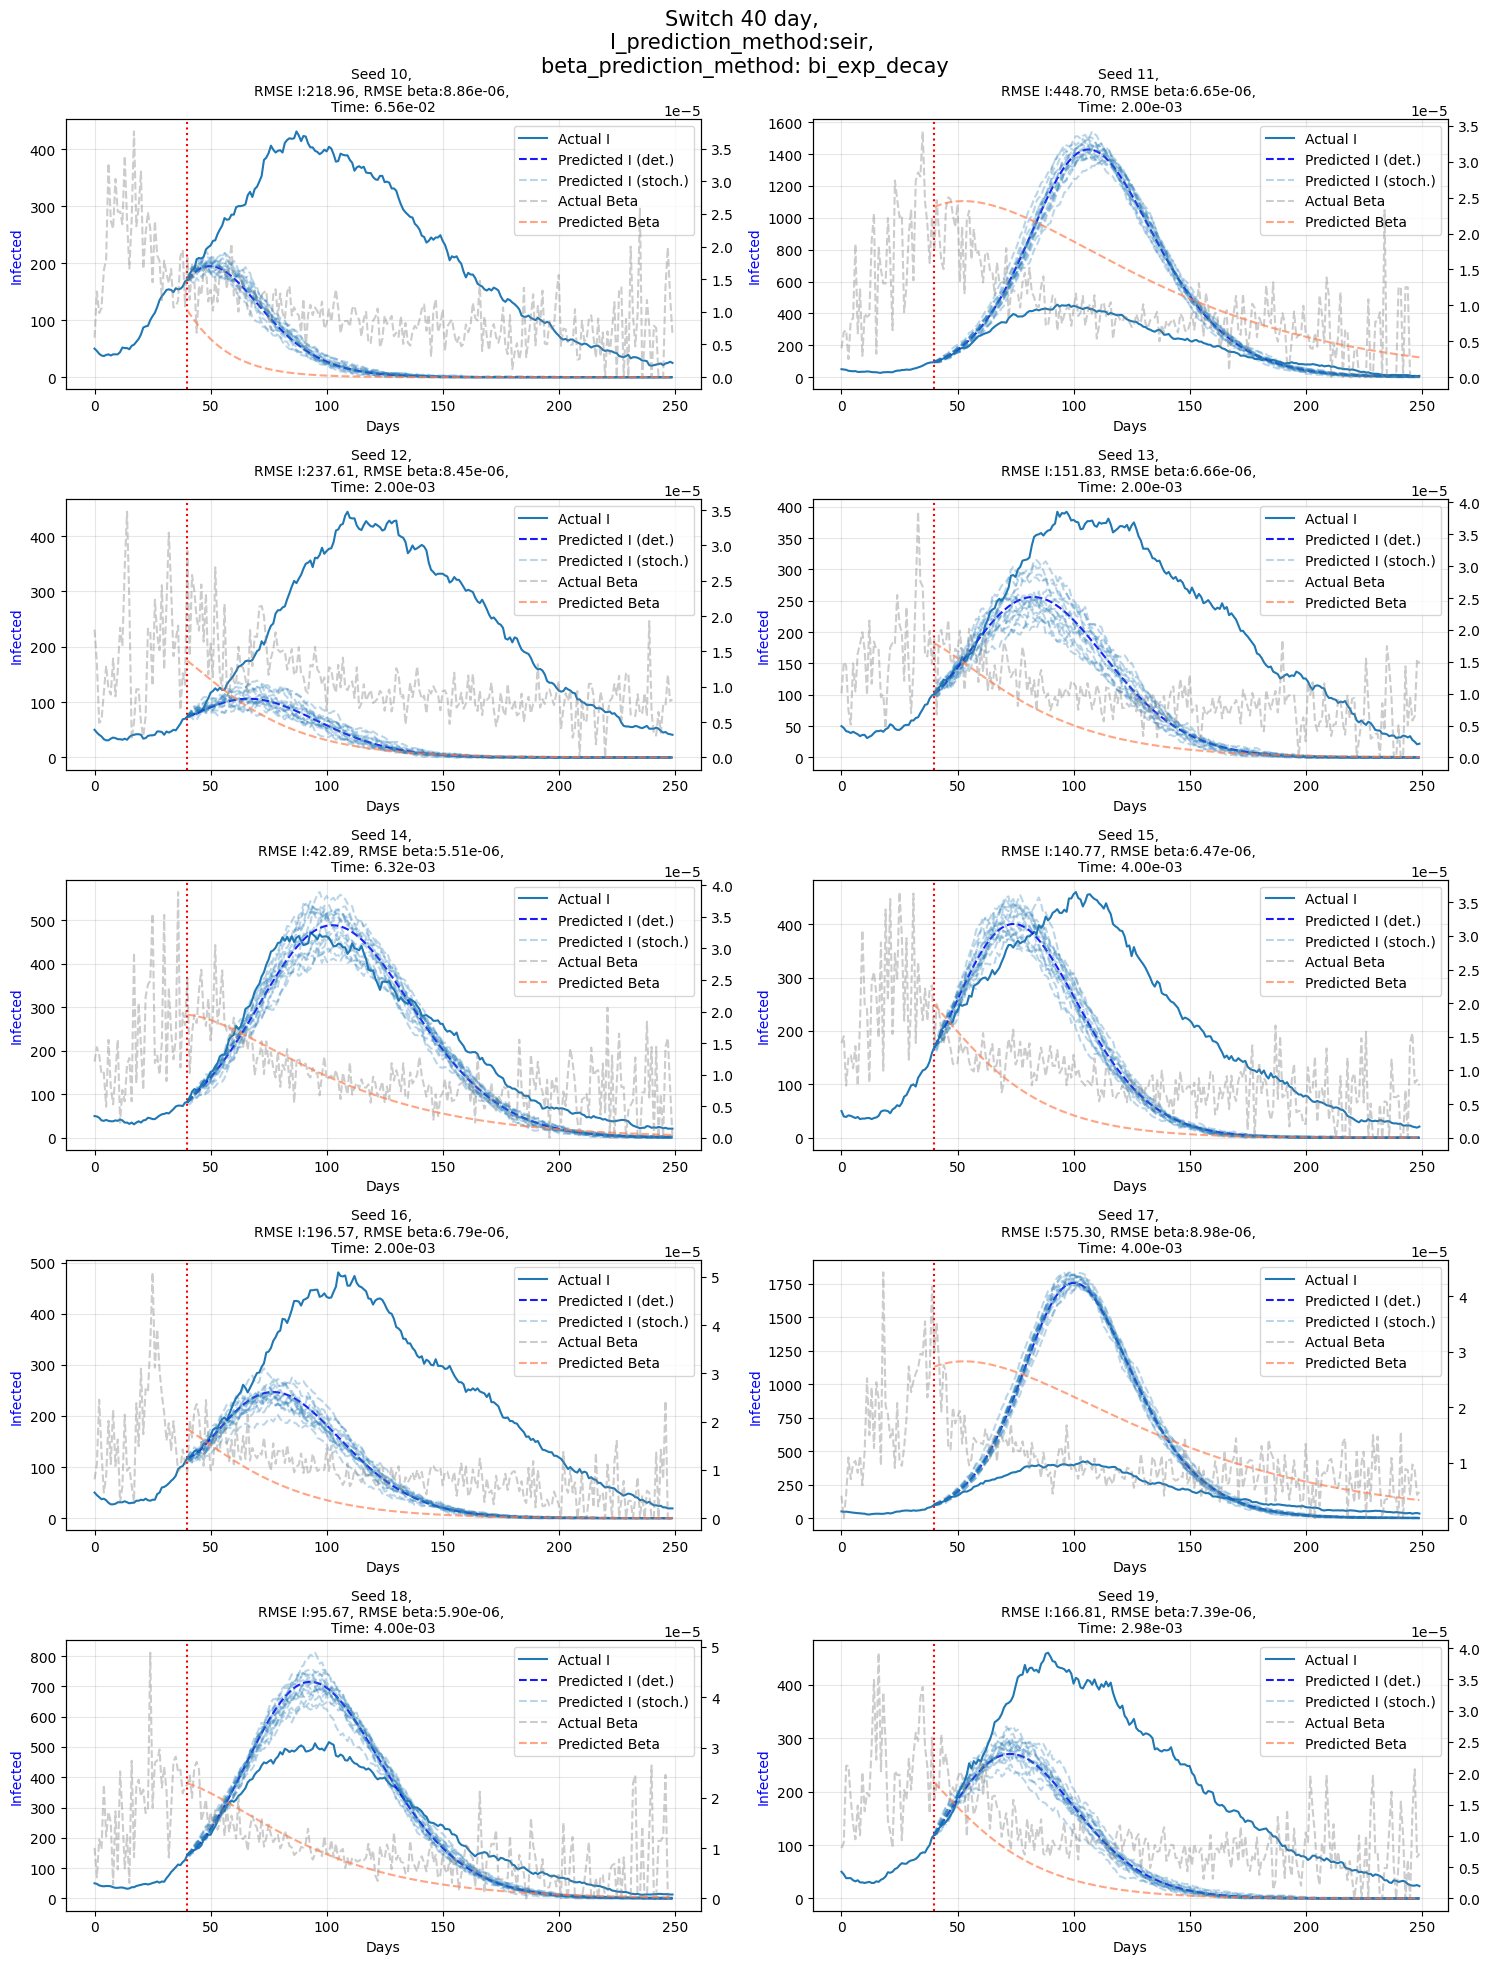

In [18]:
'''
Создание графического окна для ввода параметров
'''
def parse_seeds(seeds_input):
    ''' 
    Сортировка numbers of seeds
    '''

    # использование множества уникальных значений
    seeds = set()  
   
    parts = seeds_input.split(',') 
    for part in parts:
        if '-' in part:  # определение диапазона по тире
            start, end = part.split('-')
            seeds.update(range(int(start), int(end)))  # добавление чисел из диапазона
        else:
            seeds.add(int(part))  # добавление отдельных номеров seed
            
    return sorted(seeds)

def calculate():
    try:
        # получение значениий из полей ввода
        I_prediction_method = var_I_prediction_method.get()
        stochastic = var_stochastic.get()
        count_stoch_line = int(entry_count_stoch_line.get()) if stochastic else 0  # получение количества случайных траекторий, если включена стохастичность
        beta_prediction_method = var_beta_prediction_method.get()
        start_day = int(entry_start_day.get())
        seed_numbers = entry_seed_numbers.get()

        # сортировка numbers of seeds
        seed_numbers = parse_seeds(seed_numbers)
        
        # вызов основной функции
        result = main_f(I_prediction_method, stochastic, count_stoch_line, beta_prediction_method, start_day, seed_numbers)
        
        # вывод результата
        messagebox.showinfo("Результат", result)
    except ValueError:
        messagebox.showerror("Ошибка", "Пожалуйста, введите корректные данные.")
    except Exception as e:
        messagebox.showerror("Ошибка", f"Произошла ошибка: {str(e)}")

# создание главного окна
root = tk.Tk()
root.title("Ввод параметров")

# создание переменной для выбора мат. модели
var_I_prediction_method = tk.StringVar(value="seir")  # установка значения по умолчанию
# создание выпадающего списока для выбора мат. модели
label_I_prediction_method = tk.Label(root, text="Метод предсказания Infected:")
label_I_prediction_method.pack()
I_prediction_method_options = ["seir", "sir"]
dropdown_I_prediction_method = tk.OptionMenu(root, var_I_prediction_method, *I_prediction_method_options)
dropdown_I_prediction_method.pack()

# создание флажка для стохастичности
var_stochastic = tk.BooleanVar(value=False)
checkbox_stochastic = tk.Checkbutton(root, text="Стохастичность", variable=var_stochastic, command=lambda: toggle_stochastic_entry())
checkbox_stochastic.pack()

# создание метки и поля ввода для количество стохастических траекторий
label_count_stoch_line = tk.Label(root, text="Количество случайных траекторий:")
label_count_stoch_line.pack()
entry_count_stoch_line = tk.Entry(root)
entry_count_stoch_line.pack()
entry_count_stoch_line.config(state='disabled')  # изначальное отключение поле ввода
# функция для включения/выключения поля ввода в зависимости от состояния флажка
def toggle_stochastic_entry():
    if var_stochastic.get():
        entry_count_stoch_line.config(state='normal')  # включение поля ввода
    else:
        entry_count_stoch_line.config(state='disabled')  # отключение поля ввода

# создание переменной для выбора метода предсказания значений Beta
var_beta_prediction_method = tk.StringVar(value="polynom")  # Устанавливаем значение по умолчанию
# создание выпадающего список для выбора метода
label_beta_prediction_method = tk.Label(root, text="Метод предсказания Beta:")
label_beta_prediction_method.pack()
beta_prediction_method_options = ['polynom', 'bi_exp_decay', 'percentiles']
dropdown_beta_prediction_method = tk.OptionMenu(root, var_beta_prediction_method, *beta_prediction_method_options)
dropdown_beta_prediction_method.pack()

# создание метки и поля ввода деня переключения на мат. модель
label_start_day = tk.Label(root, text="День начала:")
label_start_day.pack()
entry_start_day = tk.Entry(root)
entry_start_day.pack()

# создание метки и поля ввода для numbers of seeds
label_seed_numbers = tk.Label(root, text="Seed_numbers (через запятую или диапазон через тире):")
label_seed_numbers.pack()
entry_seed_numbers = tk.Entry(root)
entry_seed_numbers.pack()

# создание кнопки для выполнения вычисления
button_calculate = tk.Button(root, text="Вычислить", command=calculate)
button_calculate.pack()

# запуск главного цикла приложения
root.mainloop()